# Environment

In [1]:
!pip install implicit
!pip install -U scikit-learn
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install tensorboardX

You should consider upgrading via the '/home/robot/fengyu/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/robot/fengyu/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/robot/fengyu/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/robot/fengyu/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/robot/fengyu/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/robot/fengyu/bin/python -m pip install --upgrade pip' command.


# Plotting Configuration

In [1]:
# Use seaborn style
import seaborn as sns
sns.set_style("darkgrid")

# MF utils

In [2]:
from scipy.sparse import csr_matrix
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import train_test_split, precision_at_k

def data_loader(user_item_table):
    np.random.seed(1234)
    user_item_csr = csr_matrix(user_item_table)
    user_item_train, user_item_test = train_test_split(user_item_csr, train_percentage=0.8)
    return user_item_train, user_item_test
def recommend_all(bpr, user_item_table, user_num, top_k):
    rank_list = list() 
    score_list = list()
    for user_id in range(user_num):
        reco = bpr.recommend(user_id, user_item_table, N=top_k, filter_already_liked_items=True)
        single_rank_list = [element[0] for element in reco]
        single_score_list = [element[1] for element in reco]
        rank_list.append(single_rank_list)
        score_list.append(single_score_list)
    return rank_list, score_list
def train(user_item_table, bpr=None, trainning_iter=100):
    user_item_train, user_item_test = data_loader(user_item_table)
    np.random.seed(1234)
    if bpr:
        bpr.fit(user_item_train.T.tocsr())
    else:
        bpr = BayesianPersonalizedRanking(iterations=trainning_iter)
        bpr.fit(user_item_train.T.tocsr()) 
    return bpr
def mf_neighnorhood(u_id, mf):
    return mf.similar_users(u_id)[1][0]

# Item Attributes

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from user_model import UserModel, Popularity
from calibration import *

class ItemAttributes:
    def __init__(self):
        
        self.user_num = 100 
        self.item_num = 1000
        startup_iter = 100 - 1 # start up until all itmes include
        
        self.pseudo_usermodel = UserModel(self.user_num, startup_iter)
        self.ideal_idx = self.pseudo_usermodel.add_model()
        
        ###### start-up ######
        while self.pseudo_usermodel.startup:
            self.pseudo_usermodel.recommend([None]*self.user_num, self.ideal_idx)
            self.pseudo_usermodel.new_iter()
                
        self.ideal_item_list = self.ideal_ItemList()
        
    def ideal_ItemList(self, user_model=None):
        user_ideal_list = []
        if not user_model:
            for item_vec in self.pseudo_usermodel.selected[self.ideal_idx]:
                user_ideal_list.append(np.nonzero(item_vec)[0].tolist()) # np.nonzero returns a tuple, so use np.nonzero()[0] to get the answer
        else:
            for item_vec in user_model.selected[0]:
                user_ideal_list.append(np.nonzero(item_vec)[0].tolist()) # np.nonzero returns a tuple, so use np.nonzero()[0] to get the answer
        return user_ideal_list
    

    def thresholding(self, user_model):
        # use mean as threshold
        attributes_threshold = np.mean(user_model.item_vec, axis=0) # shape : (item_vec_dim=20,)
        
        # map from "item index" to "Item Class"
        item_mapping = {}
        for item_id in range(self.item_num):
            item_vector = user_model.item_vec[item_id]
            attributes = (np.nonzero(item_vector >= attributes_threshold)[0]).tolist() # np.nonzero returns a tuple, so use np.nonzero()[0] to get the answer
            attributes_ratio = 1. / len(attributes)
            item_attributes = {single_attribute: attributes_ratio for single_attribute in attributes}
            item_mapping[item_id] = Item(item_id, item_attributes, score=None)
        
        return item_mapping
    
    def ItemDistribution(self, item_list, item_mapping):
        # elements in item_list are all item_id, and it's size is (user_num, *),  
        # e.g ranking list : (user_num, topK)
        # e.g ideal list : (user_num, num_InteractedItems_in_ideal_case)
        
        distribution_list = []
        # item mapping & compute distribution
        for user_item_list in item_list:
            preprocess_item_list = [item_mapping[item_id] for item_id in user_item_list]        
            distribution = compute_genre_distr(preprocess_item_list)
            distribution_list.append(distribution)

        return distribution_list
        

def calibration_all(rank_list, score_list, itemId2Item, ideal_distribution_list, topk, lmbda=0.99):
    calibrated_rank_list = []
    for user_id in range(len(rank_list)):

        # transform
        user_ranking_list = [itemId2Item[item_id] for item_id in rank_list[user_id]]
        user_score_list = score_list[user_id]

        # preprocess and get ideal distribution    
        for i in range(len(user_ranking_list)):
            user_ranking_list[i].score = user_score_list[i]
        
        user_ideal_distribution = ideal_distribution_list[user_id]

        # calibration
        postprocess_user_rank_list, _ = calib_recommend(user_ranking_list, user_ideal_distribution, topn=topk, lmbda=lmbda)
        calibrated_rank_list.append(postprocess_user_rank_list)
    return calibrated_rank_list

In [4]:
from gmf import GMFEngine
from mlp import MLPEngine
from neumf import NeuMFEngine
from data import SampleGenerator, UserItemRatingDataset

def prepare_dataframe(user_item_table):
    frame = list()
    for u in range(user_num):
        interacted_items = np.nonzero(user_item_table[u])[0]
        pseudo_time_stamp = 1
        for item in interacted_items:
            frame.append([u, item, 1.0, 1])

    df = pd.DataFrame(frame, columns = ['userId', 'itemId', 'rating', 'timestamp'])
    return df
def prepare_tuple(user_item_table):
    frame = list()
    for u in range(user_num):
        interacted_items = np.nonzero(user_item_table[u])[0]
        pseudo_time_stamp = 1
        for item in interacted_items:
            frame.append((u, item, 1.0))

    return frame


In [5]:
from torch.utils.data import DataLoader, Dataset
def train_mlp(user_item_table, engine=None, train_epoch=10):
    ml1m_rating = prepare_dataframe(user_item_table)
    #tt = prepare_tuple(user_model.selected[0])

    sample_generator = SampleGenerator(ratings=ml1m_rating)

    evaluate_data = sample_generator.evaluate_data

    gmf_config = {'alias': 'gmf_factor8neg4-implict',
                  'num_epoch': 200,
                  'batch_size': 32,
                  #'optimizer': 'sgd',
                  #'sgd_lr': 1e-2,
                  #'sgd_momentum': 0.9,
                  # 'optimizer': 'rmsprop',
                  # 'rmsprop_lr': 1e-3,
                  # 'rmsprop_alpha': 0.99,
                  # 'rmsprop_momentum': 0,
                  'optimizer': 'adam',
                  'adam_lr': 1e-1,
                  'num_users': 100,
                  'num_items': 1000,
                  'latent_dim': 8,
                  'num_negative': 1,
                  'l2_regularization': 0, # 0.01
                  'use_cuda': True,
                  'device_id': 0,
                  'model_dir':'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

    mlp_config = {'alias': 'mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001',
                  'num_epoch': train_epoch,
                  'batch_size': 32,  # 1024,
                  'optimizer': 'adam',
                  'adam_lr': 1e-3,
                  'num_users': 100,
                  'num_items': 1000,
                  'latent_dim': 100,
                  'num_negative': 1,
                  'layers': [200, 32],  # layers[0] is the concat of latent user vector & latent item vector
                  'l2_regularization': 0.0000001,  # MLP model is sensitive to hyper params
                  'use_cuda': True,
                  'device_id': 0,
                  'pretrain': False,
                  'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
                  'model_dir':'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}



    neumf_config = {'alias': 'neumf_factor8neg4',
                    'num_epoch': 100,
                    'batch_size': 32,
                    'optimizer': 'sgd',
                    'sgd_lr': 1.0,
                    'sgd_momentum':0.9,
                    'num_users': 100,
                    'num_items': 1000,
                    'latent_dim_mf': 8,
                    'latent_dim_mlp': 8,
                    'num_negative': 0,
                    'layers': [16],  # layers[0] is the concat of latent user vector & latent item vector
                    'l2_regularization': 0.0,
                    'use_cuda': True,
                     'device_id': 0,
                    'pretrain': False,
                    'model_dir':'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
                    }


    #print('Range of userId is [{}, {}]'.format(ml1m_rating.userId.min(), ml1m_rating.userId.max()))
    #print('Range of itemId is [{}, {}]'.format(ml1m_rating.itemId.min(), ml1m_rating.itemId.max()))
    # DataLoader for training


    if not engine:
        #config = neumf_config
        config = mlp_config
        engine = MLPEngine(config)
        #config = gmf_config
        #engine = GMFEngine(config)
        #engine = NeuMFEngine(config)
    else:
        #config = neumf_config
        #config = gmf_config
        config = mlp_config


    # config = neumf_config
    # engine = NeuMFEngine(config)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    #users, items, ratings = [], [], []
    #for u in range(user_num):
    #    interacted_items = np.nonzero(user_item_table[u])[0]
    #    for element in interacted_items:
    #        users.append(int(u))
    #        items.append(int(element))
    #        ratings.append(1.0)
        
    #dataset = UserItemRatingDataset(user_tensor=torch.LongTensor(users),
    #                                item_tensor=torch.LongTensor(items),
    #                                target_tensor=torch.FloatTensor(ratings))
    #train_loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)
    all_loss = 0
    engine.model.train()
    for epoch in range(config['num_epoch']):
        #print('Epoch {} starts !'.format(epoch))
        #print('-' * 80)
        
        total_loss = engine.train_an_epoch(train_loader, epoch_id=epoch)
        all_loss += total_loss
        #hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
        #engine.save(config['alias'], epoch, hit_ratio, ndcg)
    #print("total loss:", all_loss/config['num_epoch'])
    return engine

#engine_mlp = train_mlp(user_model.selected[0])

In [6]:
import torch
from scipy import spatial
#user = 0
#item_num = 1000
#rank_all = engine_mlp.model(torch.LongTensor([user] * item_num).to('cuda'),torch.LongTensor(list(range(item_num))).to('cuda'))        
#rank_all = torch.squeeze(rank_all)
def mlp_recommend_all(engine, user_item_table, top_k=20):
    user_num = 100
    item_num = 1000
    total_rank = []
    total_score_rank = []
    engine.model.eval()
    with torch.no_grad():
        for user in range(user_num):
            rank_all = engine.model(torch.LongTensor([user] * item_num).to('cuda'),torch.LongTensor(list(range(item_num))).to('cuda')) 
            rank_all = torch.squeeze(rank_all)
            #rank_list = torch.argsort(rank_all, dim=0, descending=True).tolist()
            score_list, rank_list = torch.sort(rank_all, descending=True)
            rank_list = rank_list.tolist()
            score_list = score_list.tolist()
            interacted_items = np.nonzero(user_item_table[user])[0]
            user_rank_list = []
            user_score_list = []

            for element_idx in range(len(rank_list)):
                element = rank_list[element_idx]
                if (len(user_rank_list) < top_k) and (element not in interacted_items):
                    user_rank_list.append(element)
                    user_score_list.append(score_list[element_idx])
            total_rank.append(user_rank_list)
            total_score_rank.append(user_score_list)
        return total_rank, total_score_rank
def mlp_neighborhood(user_id, engine):
    engine.model.eval()
    with torch.no_grad():
        user_embed = torch.squeeze(engine.model.embedding_user(torch.LongTensor([user_id]).to('cuda'))).cpu().detach().numpy()

        sim = -1e10
        indice = user_id
        for u in range(100):
            if u != user_id:
                uv = torch.LongTensor([int(u)]).to('cuda')
                u_vector = torch.squeeze(engine.model.embedding_user(uv)).cpu().detach().numpy()
                try:
                    cos = 1 - spatial.distance.cosine(user_embed, u_vector)
                except:
                    cos = np.dot(user_embed, u_vector) / (np.linalg.norm(user_embed)*np.linalg.norm(u_vector))
                if cos > sim:
                    sim = cos
                    indice = u
        if indice == user_id:
            print("ERROR")
            exit()

        return indice

In [7]:
def gini(x):
    """Compute Gini coefficient of array of values"""
    x = x.sum(0)
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [8]:
def same_seeds(seed): 
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
same_seeds(7000)

# 1.Offline Item List

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from user_model import UserModel, Popularity
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

jaccard_list = list()
jaccard_ran_list = list()
gini_list = list()

popularity_list = {"ideal":list(),"popularity":list(),"mf":list(),"mf_calibration":list(),"mlp":list(),"mlp_calibration":list()}

single_train = False

offline_item_list = True

for _ in range(1):

    _jaccard_list = list()
    _jaccard_ran_list = list()
    _gini_list= list()

    if not single_train:
        startup_iteration = 10
        mf_training_step = 100
        mlp_train_epoch = 10
        mlp_calib_lbmda = 0.9
        mf_calib_lmbda = 0.99
    else:
        startup_iteration = 10 #20
        mf_training_step = 1000
        mlp_train_epoch = 50
        mlp_calib_lbmda = 0.1
        mf_calib_lmbda = 0.7


    
    print("start up and mf training step:", startup_iteration, mf_training_step)
    
    user_num = 100
    iter_num = 100

    user_model = UserModel(user_num, 10, iter=iter_num)

    neighborhood = user_model.neighborhood()
    random_neighbor = [_u if _u < _i else _u + 1 for _i, _u in enumerate(np.random.choice(range(user_num - 1), user_num))]

    popularity_model = Popularity(user_num, 10 * iter_num)
    
    ideal_idx = user_model.add_model()
    popularity_idx = user_model.add_model()
    mf_idx = user_model.add_model()
    mf_calibration_idx = user_model.add_model()
    mlp_idx = user_model.add_model()
    mlp_calibration_idx = user_model.add_model()
    
    bpr = None # mf model
    bpr_calibration = None
    mlp = None
    mlp_calibration = None
    
    ### Calibration Config############
    pseudo_attributes = ItemAttributes()
    if offline_item_list:
        itemId2Item = pseudo_attributes.thresholding(user_model)
        ideal_distribution_list = pseudo_attributes.ItemDistribution(pseudo_attributes.ideal_item_list, itemId2Item)
    ##################################
    
    ran_jaccard = lambda _idx: np.array([user_model.jaccard(_idx, u, random_neighbor[u]) for u in range(user_num)]).mean()

    for iter in range(iter_num):
        clear_output(wait=True)
        # Ideal
        if iter < startup_iteration:
            user_model.recommend([[] for _ in range(user_num)], ideal_idx)
        else:
            user_model.recommend(user_model.get_ideal(ideal_idx), ideal_idx)

        ideal_jaccard = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        ideal_ran = ran_jaccard(ideal_idx)
        # end Ideal

        # Popularity
        if iter < startup_iteration:
            feedback = user_model.recommend([[] for _ in range(user_num)], popularity_idx)
            #if not single_train:
            popularity_model.feedback(feedback)
        else:
            pred = popularity_model.predict(user_model.selected[popularity_idx])
            feedback = user_model.recommend(pred, popularity_idx)
            if single_train and (iter == (startup_iteration - 1)):
                popularity_model.feedback(feedback)
            if not single_train:
                popularity_model.feedback(feedback)
                

        popularity_jaccard = np.array([user_model.jaccard(popularity_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        popularity_ran = ran_jaccard(popularity_idx)
        popularity_gini = gini(user_model.selected[popularity_idx])
        # end Popularity
        
        
        if not offline_item_list:
            itemId2Item = pseudo_attributes.thresholding(user_model)
            ideal_item_list = pseudo_attributes.ideal_ItemList(user_model)
            ideal_distribution_list = pseudo_attributes.ItemDistribution(ideal_item_list, itemId2Item)
        # MF & MF calibration
        if iter < startup_iteration:
            feedback = user_model.recommend([[] for _ in range(user_num)], mf_idx)
            feedback = user_model.recommend([[] for _ in range(user_num)], mf_calibration_idx)
            feedback = user_model.recommend([[] for _ in range(user_num)], mlp_idx)
            feedback = user_model.recommend([[] for _ in range(user_num)], mlp_calibration_idx)
        else:
            
            if not bpr:
                bpr = train(user_model.selected[mf_idx].copy(),None, mf_training_step)    
            if not bpr_calibration:
                bpr_calibration = train(user_model.selected[mf_calibration_idx].copy(), None, mf_training_step)
            
            if not mlp:
                mlp = train_mlp(user_model.selected[mlp_idx], None, mlp_train_epoch)
            
            if not mlp_calibration:
                mlp_calibration = train_mlp(user_model.selected[mlp_calibration_idx], None, mlp_train_epoch)
            
            ########## MF ##############
            ## Inference
            old_user_item_table = user_model.selected[mf_idx].copy()
            top_k = 20 # assume recommend 20 items to each user
            rank_list, _ = recommend_all(bpr, csr_matrix(old_user_item_table), user_num=100, top_k=top_k) # size of rank_list : (user_num, top_k)

            ## User Interaction
            user_model.recommend(rank_list, model_idx=mf_idx)
            new_user_item_table = user_model.selected[mf_idx].copy()

            ## Retrain Model
            if not single_train:
                bpr = train(new_user_item_table, bpr, mf_training_step)
            ###########################
            
            ######## MF Calibration #####
            ## Inference
            old_user_item_table = user_model.selected[mf_calibration_idx].copy()
            top_k = 20 # assume recommend 20 items to each user
            rank_list, score_list = recommend_all(bpr_calibration, csr_matrix(old_user_item_table), user_num=100, top_k=int(top_k*5)) # size of rank_list : (user_num, top_k)
            post_rank_list = calibration_all(rank_list, score_list, itemId2Item, ideal_distribution_list, topk=top_k, lmbda=mf_calib_lmbda)
            
            ## User Interaction
            user_model.recommend(post_rank_list, model_idx=mf_calibration_idx)
            new_user_item_table = user_model.selected[mf_calibration_idx].copy()

            ## Retrain Model
            if not single_train:
                bpr_calibration = train(new_user_item_table, bpr_calibration, mf_training_step)
            ###########################
            
            
            ########## MLP ##############
            ## Inference
            old_user_item_table = user_model.selected[mlp_idx].copy()
            top_k = 20 # assume recommend 20 items to each user
            rank_list, _ = mlp_recommend_all(mlp, old_user_item_table, top_k=top_k) # size of rank_list : (user_num, top_k)
            ## User Interaction
            user_model.recommend(rank_list, model_idx=mlp_idx)
            new_user_item_table = user_model.selected[mlp_idx].copy()

            ## Retrain Model
            if not single_train:
                mlp = train_mlp(new_user_item_table, mlp)
            ###########################
            
            ########## MLP Calibration ##############
            ## Inference
            old_user_item_table = user_model.selected[mlp_calibration_idx].copy()
            top_k = 20 # assume recommend 20 items to each user
            rank_list, score_list = mlp_recommend_all(mlp_calibration, old_user_item_table, top_k=int(5*top_k)) # size of rank_list : (user_num, top_k)
            post_rank_list = calibration_all(rank_list, score_list, itemId2Item, ideal_distribution_list, topk=top_k, lmbda=mlp_calib_lbmda)
            ## User Interaction
            user_model.recommend(post_rank_list, model_idx=mlp_calibration_idx)
            new_user_item_table = user_model.selected[mlp_calibration_idx].copy()

            ## Retrain Model
            if not single_train:
                mlp_calibration = train_mlp(new_user_item_table, mlp_calibration)
            ###########################
            
        
        
        if bpr:
            mf_jaccard = np.array([user_model.jaccard(mf_idx, u, mf_neighnorhood(u,bpr)) for u in range(user_num)]).mean()
            ideal_jaccard2 = np.array([user_model.jaccard(ideal_idx, u, mf_neighnorhood(u,bpr)) for u in range(user_num)]).mean()
        else:
            mf_jaccard = np.array([user_model.jaccard(mf_idx, u, neighborhood[u]) for u in range(user_num)]).mean() 
            ideal_jaccard2 = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        mf_ran = ran_jaccard(mf_idx)
        mf_gini = gini(user_model.selected[mf_idx])
        # end MF
        if bpr_calibration:
            mf_calibration_jaccard = np.array([user_model.jaccard(mf_calibration_idx, u, mf_neighnorhood(u,bpr_calibration)) for u in range(user_num)]).mean()
            ideal_jaccard3 = np.array([user_model.jaccard(ideal_idx, u, mf_neighnorhood(u,bpr_calibration)) for u in range(user_num)]).mean()
        else:
            mf_calibration_jaccard = np.array([user_model.jaccard(mf_calibration_idx, u, neighborhood[u]) for u in range(user_num)]).mean() 
            ideal_jaccard3 = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        mf_calibration_ran = ran_jaccard(mf_calibration_idx)
        mf_calibration_gini = gini(user_model.selected[mf_calibration_idx])
        # end MF calibration
        
        if mlp:
            mlp_jaccard = np.array([user_model.jaccard(mlp_idx, u, mlp_neighborhood(u,mlp)) for u in range(user_num)]).mean()
            ideal_jaccard4 = np.array([user_model.jaccard(ideal_idx, u, mlp_neighborhood(u,mlp)) for u in range(user_num)]).mean()
        else:
            mlp_jaccard = np.array([user_model.jaccard(mlp_idx, u, neighborhood[u]) for u in range(user_num)]).mean() 
            ideal_jaccard4 = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        mlp_ran = ran_jaccard(mlp_idx)
        mlp_gini = gini(user_model.selected[mlp_idx])
        
        if mlp_calibration:
            mlp_calibration_jaccard = np.array([user_model.jaccard(mlp_calibration_idx, u, mlp_neighborhood(u,mlp_calibration)) for u in range(user_num)]).mean()
            ideal_jaccard5 = np.array([user_model.jaccard(ideal_idx, u, mlp_neighborhood(u,mlp_calibration)) for u in range(user_num)]).mean()
        else:
            mlp_calibration_jaccard = np.array([user_model.jaccard(mlp_calibration_idx, u, neighborhood[u]) for u in range(user_num)]).mean() 
            ideal_jaccard5 = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        
        mlp_calibration_ran = ran_jaccard(mlp_calibration_idx)
        mlp_calibration_gini = gini(user_model.selected[mlp_calibration_idx])
        
        
        _jaccard_list.append([popularity_jaccard - ideal_jaccard, mf_jaccard - ideal_jaccard2, mf_calibration_jaccard - ideal_jaccard3, mlp_jaccard - ideal_jaccard4, mlp_calibration_jaccard - ideal_jaccard5])
        #_jaccard_list.append([popularity_jaccard - ideal_jaccard, 0,0, mlp_jaccard - ideal_jaccard4, mlp_calibration_jaccard - ideal_jaccard5])
        _jaccard_ran_list.append([popularity_ran - ideal_ran, mf_ran - ideal_ran, mf_calibration_ran - ideal_ran, mlp_ran - ideal_ran, mlp_calibration_ran - ideal_ran])
        _gini_list.append([popularity_gini, mf_gini, mf_calibration_gini, mlp_gini, mlp_calibration_gini])
        
        user_model.new_iter()
        
    popularity_list["ideal"].append(np.sum(user_model.selected[ideal_idx],axis=0))
    popularity_list["popularity"].append(np.sum(user_model.selected[popularity_idx],axis=0))    
    popularity_list["mf"].append(np.sum(user_model.selected[mf_idx],axis=0))
    popularity_list["mf_calibration"].append(np.sum(user_model.selected[mf_calibration_idx],axis=0))
    popularity_list["mlp"].append(np.sum(user_model.selected[mlp_idx],axis=0))
    popularity_list["mlp_calibration"].append(np.sum(user_model.selected[mlp_calibration_idx],axis=0))
    jaccard_list.append(_jaccard_list)
    jaccard_ran_list.append(_jaccard_ran_list)
    gini_list.append(_gini_list)
    #clear_output()

# Jaccard (similar user)

## multiple training

<Figure size 432x288 with 0 Axes>

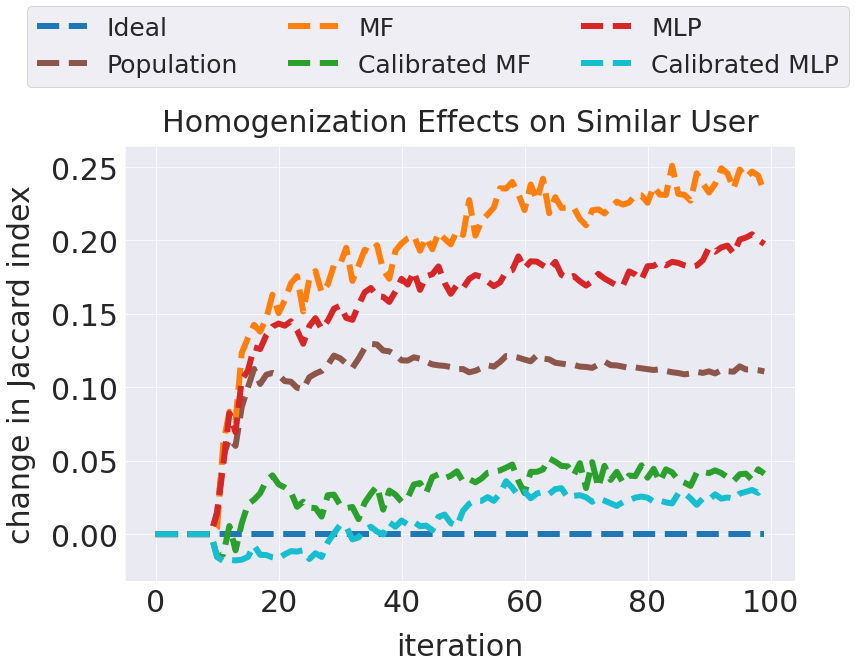

In [88]:
plt.clf()
plt.figure(figsize=(6*2,4*2))
plt.plot(list(range(np.array(jaccard_list).shape[1])), [0]*np.array(jaccard_list).shape[1],'--',label='Ideal', linewidth=6)
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,0],'--',label='Population', linewidth=6,color="tab:brown")
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,1],'--',label='MF',linewidth=6,color="tab:orange")
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,2],'--',label='Calibrated MF',linewidth=6,color="tab:green")
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,3],'--',label='MLP',linewidth=6,color="tab:red")
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,4],'--',label='Calibrated MLP',linewidth=6,color="tab:cyan")
plt.xlabel('iteration',fontsize=30,labelpad=15)
plt.ylabel('change in Jaccard index',fontsize=30,labelpad=15)
plt.title("Homogenization Effects of Repeated Training",fontsize=30,pad=15)
# plt..set_major_locator(MaxNLocator(5)) 
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.legend(bbox_to_anchor=(1.1, -0.18),fontsize=25,ncol=3)
plt.legend(bbox_to_anchor=(1.1, 1.35),fontsize=25,ncol=3)






## Single Training(重要：若要執行single training，必須設定single_train=True，並重新執行jupyter notebook)

<Figure size 432x288 with 0 Axes>

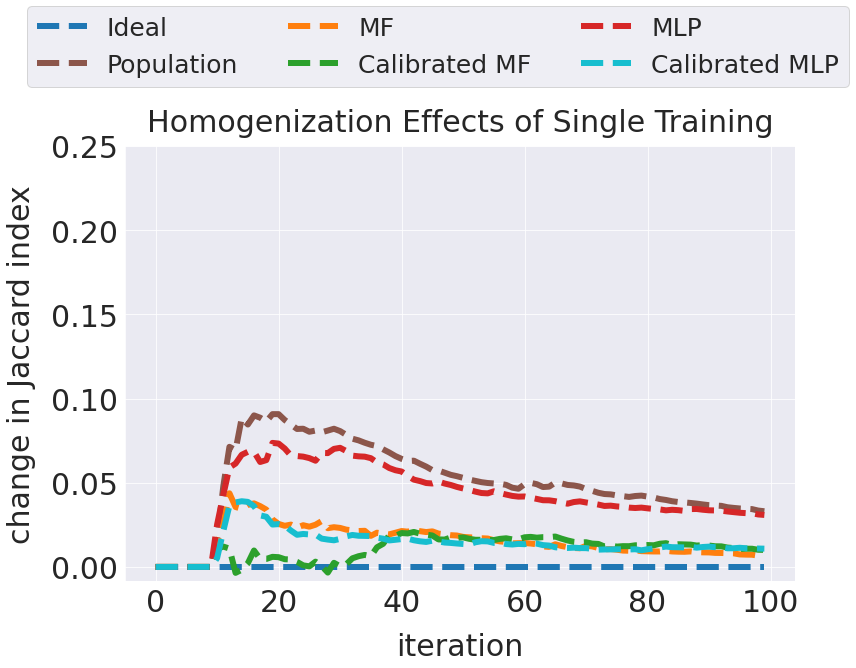

In [10]:
# plt.clf()
# plt.figure(figsize=(6*2,4*2))
# plt.plot(list(range(np.array(jaccard_list).shape[1])), [0]*np.array(jaccard_list).shape[1],'--',label='Ideal', linewidth=6)
# plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,0],'--',label='Population', linewidth=6,color="tab:brown")
# plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,1],'--',label='MF',linewidth=6,color="tab:orange")
# plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,2],'--',label='Calibrated MF',linewidth=6,color="tab:green")
# plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,3],'--',label='MLP',linewidth=6,color="tab:red")
# plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,4],'--',label='Calibrated MLP',linewidth=6,color="tab:cyan")
# plt.xlabel('iteration',fontsize=30,labelpad=15)
# plt.ylabel('change in Jaccard index',fontsize=30,labelpad=15)
# plt.title("Homogenization Effects of Single Training",fontsize=30,pad=15)
# # plt..set_major_locator(MaxNLocator(5)) 
# plt.xticks(fontsize=30)
# plt.yticks([0.0,0.05,0.10,0.15,0.20,0.25],fontsize=30)
# #plt.legend(bbox_to_anchor=(1.1, -0.18),fontsize=25,ncol=3)
# plt.legend(bbox_to_anchor=(1.1, 1.35),fontsize=25,ncol=3)



# Random

<Figure size 432x288 with 0 Axes>

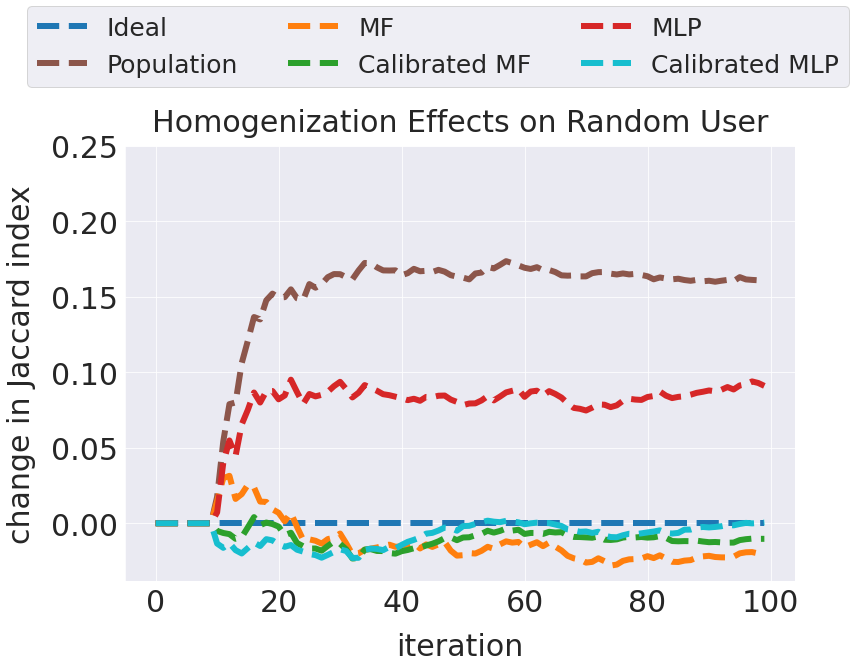

In [87]:
plt.clf()
plt.figure(figsize=(6*2,4*2))
plt.plot(list(range(np.array(jaccard_ran_list).shape[1])), [0]*np.array(jaccard_ran_list).shape[1],'--',label='Ideal', linewidth=6)
plt.plot(list(range(np.array(jaccard_ran_list).shape[1])), np.array(jaccard_ran_list).mean(axis=0)[:,0],'--',label='Population', linewidth=6,color="tab:brown")
plt.plot(list(range(np.array(jaccard_ran_list).shape[1])), np.array(jaccard_ran_list).mean(axis=0)[:,1],'--',label='MF',linewidth=6,color="tab:orange")
plt.plot(list(range(np.array(jaccard_ran_list).shape[1])), np.array(jaccard_ran_list).mean(axis=0)[:,2],'--',label='Calibrated MF',linewidth=6,color="tab:green")
plt.plot(list(range(np.array(jaccard_ran_list).shape[1])), np.array(jaccard_ran_list).mean(axis=0)[:,3],'--',label='MLP',linewidth=6,color="tab:red")
plt.plot(list(range(np.array(jaccard_ran_list).shape[1])), np.array(jaccard_ran_list).mean(axis=0)[:,4],'--',label='Calibrated MLP',linewidth=6,color="tab:cyan")
plt.xlabel('iteration',fontsize=30,labelpad=15)
plt.ylabel('change in Jaccard index',fontsize=30,labelpad=15)
plt.title("Homogenization Effects on Random User",fontsize=30,pad=15)
plt.xticks(fontsize=30)
plt.yticks([0.0,0.05,0.10,0.15,0.20,0.25],fontsize=30)
#plt.legend(bbox_to_anchor=(1.1, -0.18),fontsize=25,ncol=3)
plt.legend(bbox_to_anchor=(1.1, 1.35),fontsize=25,ncol=3)


# Popularity Distribution 
## (y-axis: rated times, x-axis: items ranked by popularity) 

In [97]:
def plot_rating_popularity(popularity_list):
    def compute_gini(x, w=None):
        x = np.asarray(x)
        if w is not None:
            w = np.asarray(w)
            sorted_indices = np.argsort(x)
            sorted_x = x[sorted_indices]
            sorted_w = w[sorted_indices]
            cumw = np.cumsum(sorted_w, dtype=float)
            cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
            return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
                    (cumxw[-1] * cumw[-1]))
        else:
            sorted_x = np.sort(x)
            n = len(x)
            cumx = np.cumsum(sorted_x, dtype=float)
            return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    ideal_popularity = np.mean(np.array(popularity_list["ideal"]),axis=0)
    popu_popularity = np.mean(np.array(popularity_list["popularity"]),axis=0)
    mf_popularity = np.mean(np.array(popularity_list["mf"]),axis=0)
    mf_calibration_popularity = np.mean(np.array(popularity_list["mf_calibration"]),axis=0)
    mlp_popularity = np.mean(np.array(popularity_list["mlp"]),axis=0)
    mlp_calibration_popularity = np.mean(np.array(popularity_list["mlp_calibration"]),axis=0)
    
    
    sort_ideal_popularity = np.sort(ideal_popularity)[::-1]
    sort_popu_popularity = np.sort(popu_popularity)[::-1]
    sort_mf_popularity = np.sort(mf_popularity)[::-1]
    sort_mlp_popularity = np.sort(mlp_popularity)[::-1]
    sort_mf_calibration_popularity = np.sort(mf_calibration_popularity)[::-1]
    sort_mlp_calibration_popularity = np.sort(mlp_calibration_popularity)[::-1]

    plt.clf()
    plt.figure(figsize=(6*2,4*2))
    plt.plot(range(sort_ideal_popularity.shape[0]),sort_ideal_popularity,'--',label="Ideal",linewidth=6)
    plt.plot(range(sort_popu_popularity.shape[0]),sort_popu_popularity,'--',label="Popularity",linewidth=6,color="tab:brown")
    plt.plot(range(sort_mf_popularity.shape[0]),sort_mf_popularity,'--',label="MF",linewidth=6,color="tab:orange")
    plt.plot(range(sort_mf_calibration_popularity.shape[0]),sort_mf_calibration_popularity,'--',label="Calibrated MF",linewidth=6,color="tab:green")
    plt.plot(range(sort_mlp_popularity.shape[0]),sort_mlp_popularity,'--',label="MLP",linewidth=6,color="tab:red")
    plt.plot(range(sort_mlp_popularity.shape[0]),sort_mlp_calibration_popularity,'--',label="Calibrated MLP",linewidth=6,color="tab:cyan")
    
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=25)
    plt.title(r'Item popularity of 100 iterations',fontsize=30,pad=15)
    plt.xlabel('Items ranked by popularity',fontsize=30,labelpad=15)
    plt.ylabel('Number of ratings',fontsize=30,labelpad=15)
    print("ideal gini",compute_gini(sort_ideal_popularity))
    print("mf gini",compute_gini(sort_mf_popularity))
    print("mf calibration gini",compute_gini(sort_mf_calibration_popularity))
    plt.show()


ideal gini 0.6919392
mf gini 0.6853226
mf calibration gini 0.6919446


<Figure size 432x288 with 0 Axes>

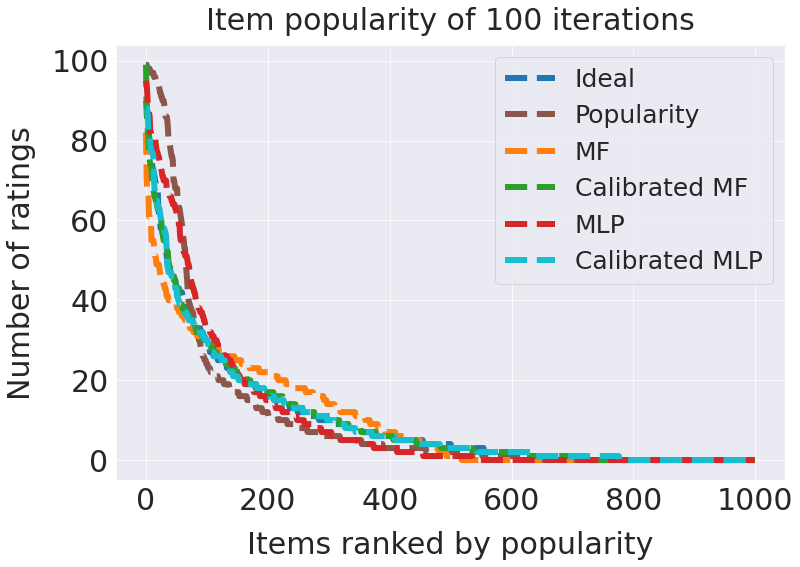

In [98]:
plot_rating_popularity(popularity_list)


# Calibration Effect on Attributes Distribution
## Take the model "mf" as example

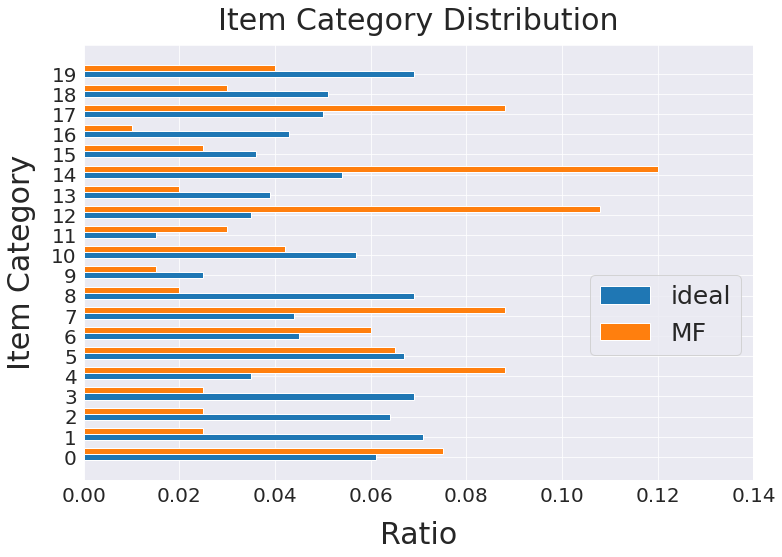

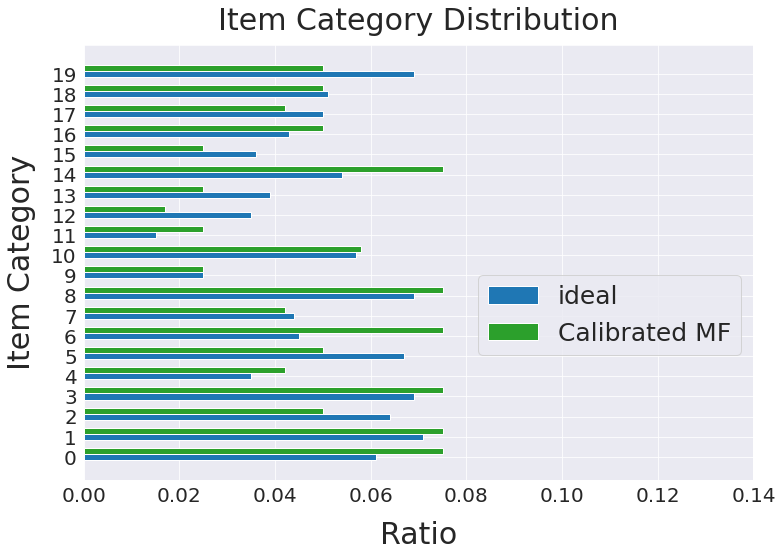

In [101]:

import pandas as pd

def two_distr_comparison_plot(interacted_distr, reco_distr, plot_label, color_label, width=0.3):
    """
    Input : two dict
    eample for single dict:
        {'Comedy': 0.062,
         'Horror': 0.225,
         'Thriller': 0.163,
         'Action': 0.087,
         'Fantasy': 0.129,
         'Adventure': 0.108,
         'Drama': 0.029,
         'Sci-Fi': 0.071,
         'Mystery': 0.046,
         'Animation': 0.037,
         'Children': 0.029,
         'Romance': 0.013}
    """
    # the value will automatically be converted to a column with the
    # column name of '0'
    interacted = pd.DataFrame.from_dict(interacted_distr, orient='index')
    reco = pd.DataFrame.from_dict(reco_distr, orient='index')
    df = interacted.join(reco, how='outer', lsuffix='_interacted')

    plt.figure(figsize=(6*2,4*2))

    n = df.shape[0]
    index = np.arange(n)
    plt.barh(index, df['0_interacted'], height=width, label=plot_label[0], color=color_label[0])
    plt.barh(index + width, df['0'], height=width, label=plot_label[1], color=color_label[1])
    plt.yticks(index, df.index, fontsize=20)
    plt.xticks(np.array([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]), fontsize=20)
    plt.legend(bbox_to_anchor=(1, 0.5),fontsize=25)
    plt.title('Item Category Distribution',fontsize=30,pad=15)
    plt.ylabel('Item Category',fontsize=30,labelpad=15)
    plt.xlabel('Ratio',fontsize=30,labelpad=15)
    plt.show()
    
def distr_comparison_plot(interacted_distr, reco_distr, calibrated_reco_distr, width=0.3):
    """
    Input : two dict
    eample for single dict:
        {'Comedy': 0.062,
         'Horror': 0.225,
         'Thriller': 0.163,
         'Action': 0.087,
         'Fantasy': 0.129,
         'Adventure': 0.108,
         'Drama': 0.029,
         'Sci-Fi': 0.071,
         'Mystery': 0.046,
         'Animation': 0.037,
         'Children': 0.029,
         'Romance': 0.013}
    """
    # the value will automatically be converted to a column with the
    # column name of '0'
    interacted = pd.DataFrame.from_dict(interacted_distr, orient='index',columns=['0_interacted'])
    reco = pd.DataFrame.from_dict(reco_distr, orient='index',columns=['0'])
    calibrated_reco = pd.DataFrame.from_dict(calibrated_reco_distr, orient='index',columns=['0_calibrated'])
    
    df = interacted.join(reco, how='outer')
    df = df.join(calibrated_reco, how='outer')
    #print(df.head())
    
    n = df.shape[0]
    index = np.arange(n)
    print(index)
    print(df['0_interacted'].values)
    plt.figure(figsize=(6*1.5,4*1.5))

    plt.barh(index, df['0_interacted'], height=width, label='ideal distr')
    plt.barh(index + width, df['0'], height=width, label='reco distr')
    plt.barh(index - width, df['0_calibrated'], height=width, label='calibrated reco distr')
    plt.yticks(index, df.index)
    plt.xticks(np.array([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]))
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.title('Item Attributes Distribution')
    plt.ylabel('Item Attribute')
    plt.xlabel('Ratio')
    plt.show()
    

u_id = 10
topk = 20
rank_list, score_list = recommend_all(bpr, csr_matrix(user_model.selected[mf_idx]), user_num=100, top_k=int(topk*5)) # size of rank_list : (user_num, top_k)
post_rank_list = calibration_all(rank_list, score_list, itemId2Item, ideal_distribution_list, topk=topk, lmbda=0.99)
rank_distr = pseudo_attributes.ItemDistribution([rank_list[u_id]],itemId2Item)[0]
post_rank_distr = pseudo_attributes.ItemDistribution([post_rank_list[u_id]],itemId2Item)[0]
#distr_comparison_plot(ideal_distribution_list[u_id],rank_distr, post_rank_distr)
two_distr_comparison_plot(ideal_distribution_list[u_id],rank_distr, ["ideal","MF"],['tab:blue','tab:orange'])
two_distr_comparison_plot(ideal_distribution_list[u_id],post_rank_distr, ["ideal","Calibrated MF"],['tab:blue','tab:green'])
